In [0]:
#Importación de librerías
try:
  
  #Para usar colab
  from google.colab import drive
  drive.mount('/content/drive')
  
  import numpy as np
  import pandas as pd
  
except:
  
  import numpy as np
  import pandas as pd

import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline

import seaborn as sns
sns.set()

In [0]:
#Lectura de datos
try:
  #Caso en que se este usando jupyter notebooks
  data_pulsar = pd.read_csv('HTRU_2_con_header.csv')
  head = ['mean_IP', 'std_IP','kurt_IP','skew_IP','mean_DM', 'std_DM','kurt_DM','skew_DM','is_pulsar']
except:
  #Caso en que se use colab, cambiar directorio de acuerdo al drive
  dir_str ='drive/My Drive/CURSOS - MAESTRIA/APRENDIZAJE AUTOMÁTICO/MACHINE LEARNING - PROYECTO/ML_PULSAR_CLASSIFICATION_PROJECT/PREPROCESAMIENTO DE DATA/HTRU_2_sin_header.csv'
  #Se definen  los headers
  head = ['mean_IP', 'std_IP','kurt_IP','skew_IP','mean_DM', 'std_DM','kurt_DM','skew_DM','is_pulsar']
  #Lectura de la data
  data_pulsar = pd.read_csv(dir_str,header=None, names=head)

In [0]:
from sklearn.model_selection import train_test_split

#Partición de la data cruda
X = data_pulsar.drop(columns=["is_pulsar"])
y = data_pulsar["is_pulsar"]

X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.15, random_state=0) #random_state = 0, para mantener la particion
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.2, random_state=0)

## **Escalamiento de la data**

In [0]:
#Escalamiento 
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(data_pulsar)
data_pulsar_scaled = pd.DataFrame(scaler.transform(data_pulsar), columns = head)
data_pulsar_scaled.describe()

#Partición de la data escalada
X_sca = data_pulsar_scaled.drop(columns=["is_pulsar"])
y_sca = data_pulsar_scaled["is_pulsar"]

X_trainval_sca, X_test_sca, y_trainval_sca, y_test_sca = train_test_split(X_sca, y_sca, test_size=0.15, random_state=0) #random_state = 0, para mantener la particion
X_train_sca, X_val_sca, y_train_sca, y_val_sca = train_test_split(X_trainval_sca, y_trainval_sca, test_size=0.2, random_state=0)

## **APLICACIÓN DE SMOTETomek** 

In [9]:
#Antes de aplicar SMOTETomek 
y_train_sca.value_counts()

0.0    11020
1.0     1150
Name: is_pulsar, dtype: int64

In [0]:
#https://imbalanced-learn.org/en/stable/generated/imblearn.over_sampling.ADASYN.html#imblearn.over_sampling.ADASYN

from collections import Counter
from imblearn.combine import SMOTETomek
smt = SMOTETomek(random_state=0)
X_resampled, y_resampled = smt.fit_resample(X_train_sca, y_train_sca)
X_smt_train = pd.DataFrame(X_resampled)
y_smt_train = pd.Series(y_resampled)

In [0]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error, confusion_matrix
def eval_model(model, X_val, y_val):
  #Realizando la prediccion del modelo
  y_pred = model.predict(X_val)
  #Calculando el error cuadratico medio
  MSE =mean_squared_error(y_val, y_pred)
  #Generando la matriz de confusion
  conf = confusion_matrix(y_val, y_pred)
  #Calculando las metricas
  accuracy = accuracy_score(y_val, y_pred)
  precision = precision_score(y_val, y_pred)
  recall = recall_score(y_val, y_pred)
  f1score = f1_score(y_val, y_pred)
  
  #Print de las metricas
  print('El MSE para el modelo '+type(model).__name__ +' es: ',MSE)
  print('El accuracy para el modelo '+type(model).__name__ +' es: ',accuracy)
  print('El precision para el modelo '+type(model).__name__ +' es: ',precision)
  print('El recall para el modelo '+type(model).__name__ +' es: ',recall)
  print('El F1-score para el modelo '+type(model).__name__ +' es: ',f1score)
  
  sns.heatmap(conf,annot=True, fmt="d", cmap="coolwarm");
  return None

# **1° Prueba de algoritmo: Random Forest**

El MSE para el modelo RandomForestClassifier es:  0.3480118304304962
El accuracy para el modelo RandomForestClassifier es:  0.6519881695695038
El precision para el modelo RandomForestClassifier es:  0.20676691729323307
El recall para el modelo RandomForestClassifier es:  0.985663082437276
El F1-score para el modelo RandomForestClassifier es:  0.3418272218769422


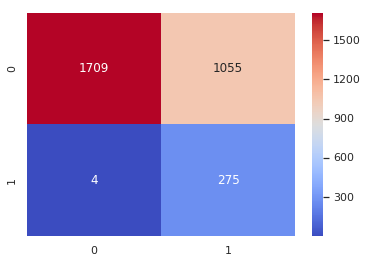

In [20]:
from sklearn.ensemble import RandomForestClassifier

RF_model = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
RF_model.fit(X_smt_train, y_smt_train)

eval_model(RF_model,X_val,y_val)

# **2° Prueba de algoritmo: SVM**

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


El MSE para el modelo SVC es:  0.09168583634571147
El accuracy para el modelo SVC es:  0.9083141636542885
El precision para el modelo SVC es:  0.0
El recall para el modelo SVC es:  0.0
El F1-score para el modelo SVC es:  0.0


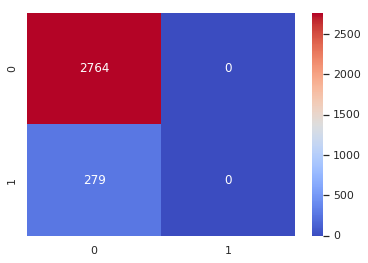

In [21]:
from sklearn.svm import SVC

SVM_model = SVC(gamma='auto',kernel='rbf')
SVM_model.fit(X_smt_train, y_smt_train) 
eval_model(SVM_model,X_val,y_val)

# **3° Prueba de algoritmo: KNN**

El MSE para el modelo KNeighborsClassifier es:  0.0874137364442984
El accuracy para el modelo KNeighborsClassifier es:  0.9125862635557016
El precision para el modelo KNeighborsClassifier es:  1.0
El recall para el modelo KNeighborsClassifier es:  0.04659498207885305
El F1-score para el modelo KNeighborsClassifier es:  0.08904109589041095


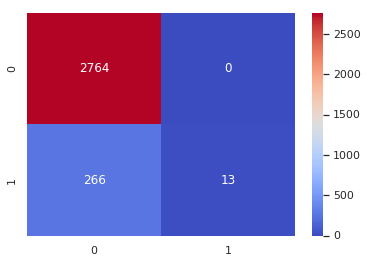

In [22]:
from sklearn.neighbors import KNeighborsClassifier

KNN_model2 = KNeighborsClassifier(n_neighbors=5)
KNN_model2.fit(X_smt_train, y_smt_train) 

eval_model(KNN_model2, X_val, y_val)

# 4° Prueba de algoritmo: ANN -Multi-layer Perceptron


El MSE para el modelo MLPClassifier es:  0.03812027604337825
El accuracy para el modelo MLPClassifier es:  0.9618797239566218
El precision para el modelo MLPClassifier es:  0.9939393939393939
El recall para el modelo MLPClassifier es:  0.5878136200716846
El F1-score para el modelo MLPClassifier es:  0.7387387387387387


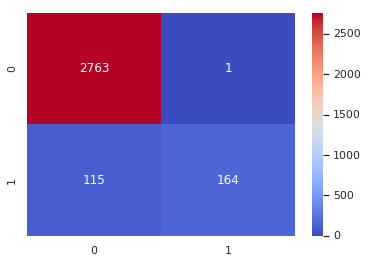

In [23]:
from sklearn.neural_network import MLPClassifier

NN_model2 = MLPClassifier()
NN_model2.fit(X_smt_train, y_smt_train) 

eval_model(NN_model2, X_val, y_val)